In [11]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, concatenate, LSTM
import matplotlib.pyplot as plt

In [12]:
ROOT_PATH = os.path.dirname(os.path.realpath('__file__'))

In [13]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [14]:
with np.load(os.path.join(ROOT_PATH, 'database', 'data.npz'), allow_pickle=True) as f:
    dados_brutos = f['arr_0']

In [15]:
data = pd.DataFrame(dados_brutos,
                    columns=['url', 'date', 'max_price', 'min_price', 'average_price', 'sellers_count'])
data = data.astype({"url": np.str, "date": np.str, "max_price": np.float16, "min_price": np.float16,
                    "average_price": np.float16, "sellers_count": np.int8})
data['date'] = data['date'].apply(lambda x: pd.to_datetime(x, utc=True))

In [74]:
data = data[data['sellers_count'] != 0]
data = data[data['sellers_count'] != 1]

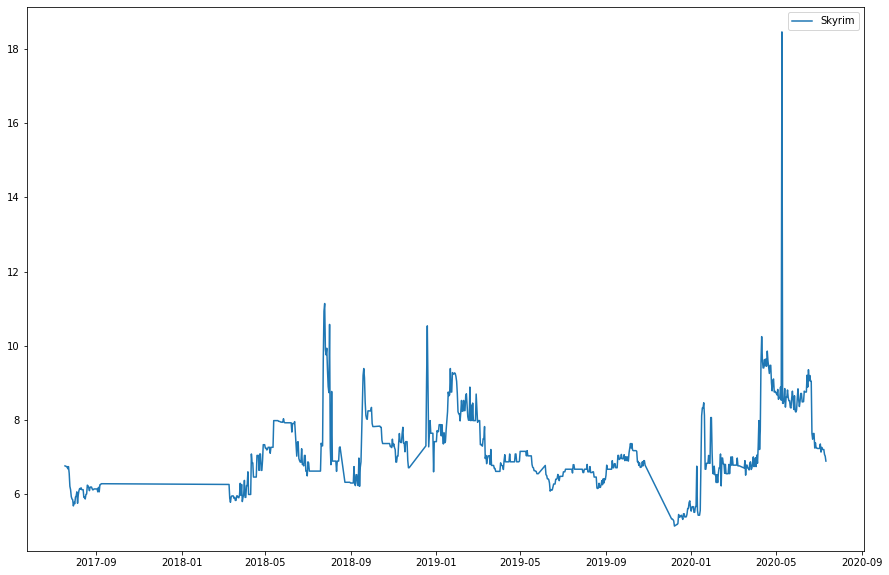

In [78]:
plt.figure(figsize = (15,10))
plt.plot(data['date'].dt.date, data['average_price'], label='Skyrim')
plt.legend(loc='best')

In [79]:
data['MA_window_10'] = data['average_price'].rolling(10).mean().shift() 
data['MA_window_20'] = data['average_price'].rolling(20).mean().shift() 

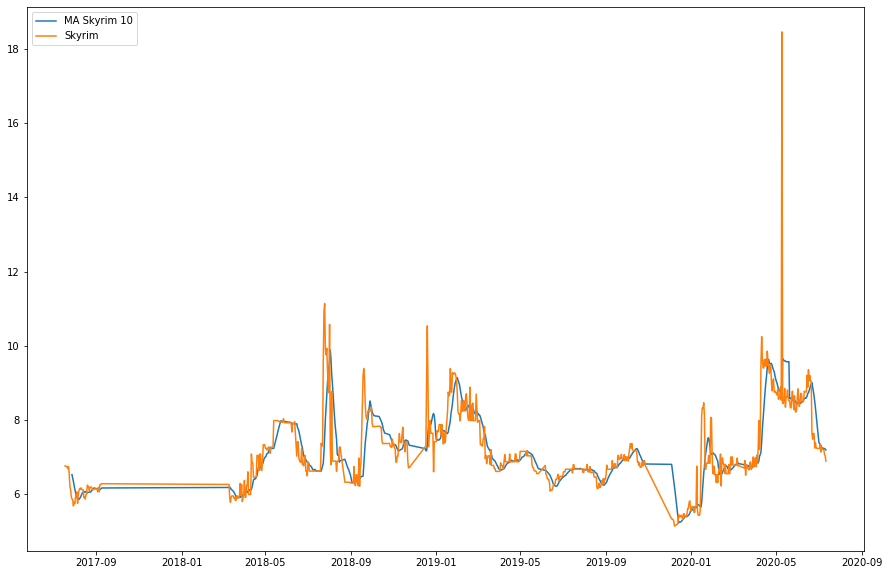

In [80]:
plt.figure(figsize = (15,10))
plt.plot(data['date'].dt.date, data['MA_window_10'], label='MA Skyrim 10')
plt.plot(data['date'].dt.date, data['average_price'], label='Skyrim')
plt.legend(loc='best')

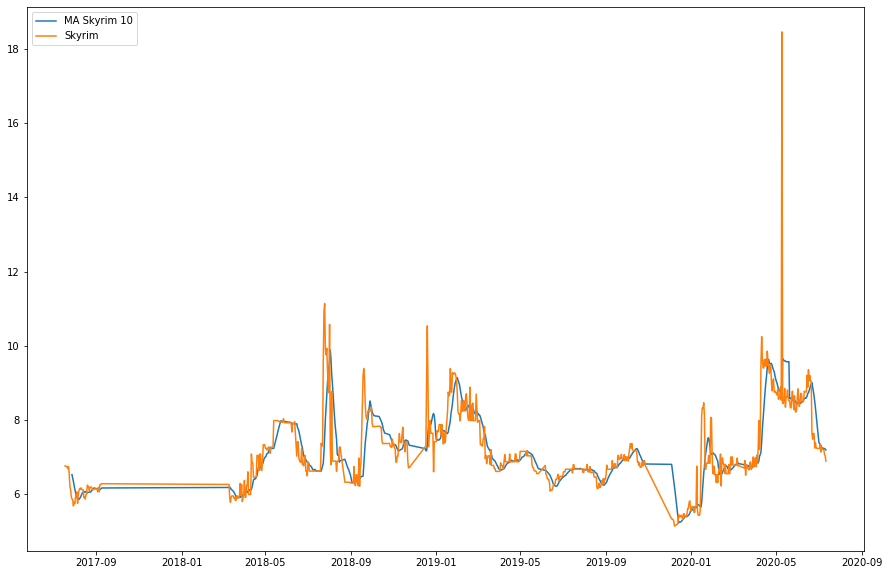

In [81]:
plt.figure(figsize = (15,10))
plt.plot(data['date'].dt.date, data['MA_window_10'], label='MA Skyrim 10')
plt.plot(data['date'].dt.date, data['average_price'], label='Skyrim')
plt.legend(loc='best')

In [82]:
look_back = 7
forward_days = 7
num_periods = 20
NUM_NEURONS_FirstLayer = 128
NUM_NEURONS_SecondLayer = 64
EPOCHS = 150

In [83]:
array = np.reshape(data['average_price'].values, (-1,1))
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [84]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)

In [85]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [86]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [87]:
def create_model():
    model = Sequential()
    model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
    model.add(Dense(32))
    model.add(Dense(forward_days))
    return model

# Export to model format
def save_model(model, name='model1'):
    pathModel = os.path.join(ROOT_PATH, 'models', '{0}.json'.format(name))
    pathWeights = os.path.join(ROOT_PATH, 'models', '{0}.h5'.format(name))
    # serialize model to JSON
    model_json = model.to_json()
    with open(pathModel, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(pathWeights)
    print("Saved model to disk")
    
# load json and create model
def load_model_from_json(name='model1'):
    pathModel = os.path.join(ROOT_PATH, 'models', '{0}.json'.format(name))
    pathWeights = os.path.join(ROOT_PATH, 'models', '{0}.h5'.format(name))
    json_file = open(pathModel, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(pathWeights)
    print("Loaded model from disk")
    return loaded_model

In [88]:
model_name = 'model2'

In [89]:
model = create_model()
model.compile(loss='mean_squared_error', optimizer='adam')

In [90]:
history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 528 samples, validate on 132 samples
Epoch 1/150
528/528 - 4s - loss: 2.5039 - val_loss: 0.8541
Epoch 2/150
528/528 - 1s - loss: 0.8413 - val_loss: 0.5730
Epoch 3/150
528/528 - 1s - loss: 0.5806 - val_loss: 0.7640
Epoch 4/150
528/528 - 1s - loss: 0.4737 - val_loss: 0.3349
Epoch 5/150
528/528 - 1s - loss: 0.4665 - val_loss: 0.4442
Epoch 6/150
528/528 - 1s - loss: 0.4299 - val_loss: 0.5774
Epoch 7/150
528/528 - 1s - loss: 0.3966 - val_loss: 0.2981
Epoch 8/150
528/528 - 1s - loss: 0.4095 - val_loss: 0.2867
Epoch 9/150
528/528 - 1s - loss: 0.3760 - val_loss: 0.3483
Epoch 10/150
528/528 - 1s - loss: 0.3841 - val_loss: 0.2971
Epoch 11/150
528/528 - 1s - loss: 0.3954 - val_loss: 0.3451
Epoch 12/150
528/528 - 1s - loss: 0.3754 - val_loss: 0.3930
Epoch 13/150
528/528 - 1s - loss: 0.3749 - val_loss: 0.3133
Epoch 14/150
528/528 - 1s - loss: 0.3781 - val_loss: 0.2976
Epoch 15/150
528/528 - 1s - loss: 0.3906 - val_loss: 0.3835
Epoch 16/150
528/528 - 1s - loss: 0.3827 - val_loss: 0.3031
Epo

Epoch 137/150
528/528 - 1s - loss: 0.2774 - val_loss: 0.3344
Epoch 138/150
528/528 - 1s - loss: 0.2711 - val_loss: 0.3604
Epoch 139/150
528/528 - 1s - loss: 0.2700 - val_loss: 0.3141
Epoch 140/150
528/528 - 1s - loss: 0.2756 - val_loss: 0.3476
Epoch 141/150
528/528 - 1s - loss: 0.2742 - val_loss: 0.3342
Epoch 142/150
528/528 - 1s - loss: 0.2895 - val_loss: 0.3640
Epoch 143/150
528/528 - 1s - loss: 0.2821 - val_loss: 0.3285
Epoch 144/150
528/528 - 1s - loss: 0.2651 - val_loss: 0.3279
Epoch 145/150
528/528 - 2s - loss: 0.2535 - val_loss: 0.3086
Epoch 146/150
528/528 - 1s - loss: 0.2688 - val_loss: 0.3301
Epoch 147/150
528/528 - 1s - loss: 0.2655 - val_loss: 0.3268
Epoch 148/150
528/528 - 1s - loss: 0.2629 - val_loss: 0.3777
Epoch 149/150
528/528 - 1s - loss: 0.2582 - val_loss: 0.3378
Epoch 150/150
528/528 - 1s - loss: 0.2574 - val_loss: 0.3332


In [28]:
save_model(model, model_name)

Saved model to disk


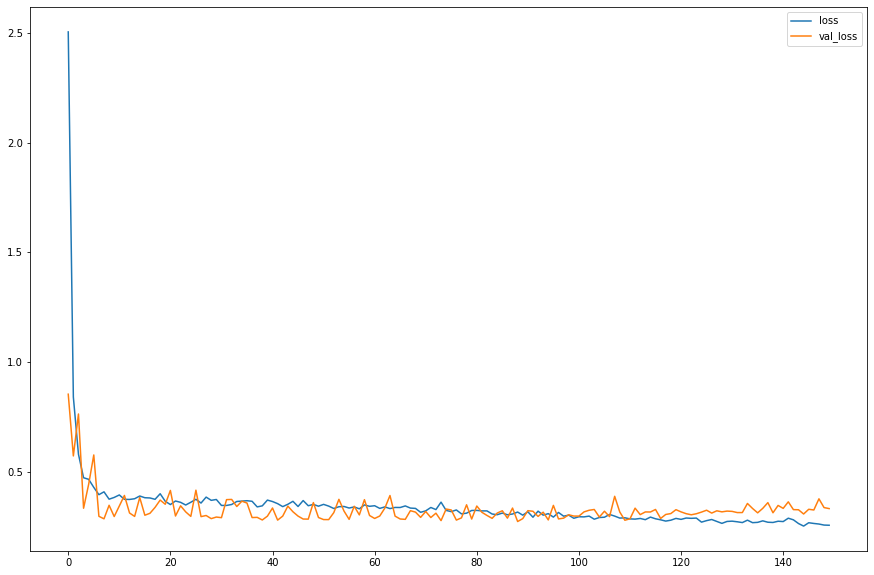

In [91]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [92]:
Xt = model.predict(X_test)

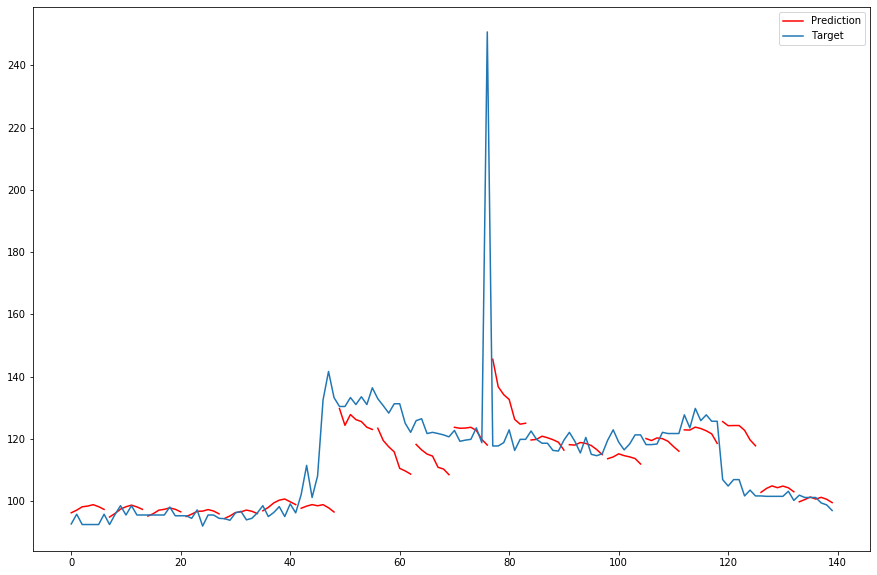

In [93]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [48]:
Xt

array([[6.7737646, 6.686561 , 6.709817 , 6.7244687, 6.7175026],
       [7.1714883, 7.1169276, 7.133344 , 7.0742807, 7.0291624],
       [8.57778  , 8.719347 , 8.585324 , 8.087992 , 8.21596  ],
       [8.961865 , 9.083086 , 8.852926 , 8.183207 , 8.528889 ],
       [8.983762 , 9.077923 , 8.834073 , 8.22193  , 8.567036 ],
       [8.693925 , 8.641889 , 8.580873 , 8.325489 , 8.408993 ],
       [8.624532 , 8.484468 , 8.518912 , 8.456938 , 8.405735 ],
       [8.811032 , 8.602204 , 8.698824 , 8.677832 , 8.592871 ],
       [7.0747366, 7.472421 , 7.0052676, 6.790069 , 6.7982874],
       [8.600329 , 8.3948145, 8.479516 , 8.477758 , 8.397062 ],
       [8.495194 , 8.29326  , 8.374457 , 8.413633 , 8.330917 ],
       [8.641501 , 8.451715 , 8.531432 , 8.533282 , 8.447834 ],
       [8.860631 , 8.612625 , 8.747451 , 8.725422 , 8.542349 ],
       [8.834912 , 8.619607 , 8.728879 , 8.7141   , 8.576132 ],
       [8.875671 , 8.66968  , 8.778957 , 8.754513 , 8.618737 ],
       [9.09732  , 9.007816 , 9.023034 ,